# ex3-qal9000 Demo: StateTomography on QAL9000

This demonstration was given at QC Norway event given in December 2022. The demonstration can be viewed on youtube [here](https://www.youtube.com/watch?v=PP3F9pcZgL8). A blog post was written about the event [here](https://nordiquest.net/_posts/2022-12-13-Nordiquest_QC_Norway/).



In [15]:
# This code is part of Tergite
#
# (C) Copyright Axel Andersson 2022
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the current directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.
#
# Modified:
# Martin Ahindura 2024
# Jake Muff 2024

## Install the Necessary Libraries

In [ ]:
%pip install "qiskit-terra==0.22.0" "qiskit-aer>=0.11.0" tqdm matplotlib "qiskit-experiments>=0.4.0" "qiskit-ignis>=0.7.1" "qiskit-ibmq-provider>=0.19.2" "pandas>=1.4.2"


## Import necessary libraries

In [17]:
import contextlib
import time
from datetime import datetime
from os import environ, listdir, makedirs
from pathlib import Path
from shutil import move

import matplotlib.pyplot as plt
import numpy as np
import qiskit.circuit as circuit
import qiskit.compiler as compiler
from qiskit.ignis.verification.tomography import (
    StateTomographyFitter,
    state_tomography_circuits,
)
from qiskit.providers.fake_provider import FakeManilaV2
from qiskit.providers.jobstatus import JobStatus
from qiskit.visualization import plot_bloch_multivector
from tqdm.auto import tqdm

## Initialize variables

In [19]:
# These variables would be important if you were connecting directly to QAL 9000 service
# Instead, we will be using a local simulator
# NOTE: The environment variables: QAL9000_API_URL and QAL9000_API_TOKEN should have been set
#       to their appropriate values
#
# API_URL = environ.get("QAL9000_API_URL", default="https://api.qal9000.se")
# API_TOKEN = environ.get("QAL9000_API_TOKEN")
# # the name of this service. For your own bookkeeping.
# SERVICE_NAME = "local"

folder = Path("demo_bloch_frames").resolve()

Function to save old frames

In [20]:
def save_old_frames():
    global folder
    saved_folder = folder / "saved_animations"
    makedirs(saved_folder, exist_ok=True)

    old_frames = [f for f in listdir(folder) if f.endswith(".jpg")]

    if len(old_frames):
        now_time = datetime.now()
        mstr = now_time.strftime("%Y%m%d%H%M%S")
        new_dir = saved_folder / mstr
        makedirs(new_dir, exist_ok=True)
        for f in old_frames:
            move(folder / f, new_dir / f)


save_old_frames()

## Initialize the backend 

In [21]:
# If we were to connect to QAL 9000, we would have to initialize a provider account
# with the right API_TOKEN and get the right backend: 
#
# account = ProviderAccount(service_name=SERVICE_NAME, url=API_URL, token=API_TOKEN)
# chalmers = Tergite.use_provider_account(account)
# backend = chalmers.get_backend("SimulatorC")
# backend.set_options(shots=2000)

# Instead, we will use a local simulator
backend = FakeManilaV2()

print(f"Loaded backend {backend.name}")

Loaded backend fake_manila_v2


## Build StateTomography circuits

In [22]:
# Define theta values
thetadef = -1 * np.asarray([0, np.pi / 2, np.pi])


# Function to generate tomography circuits
def tomog_circs(theta):
    q = circuit.QuantumRegister(1)
    circ = circuit.QuantumCircuit(q)
    circ.barrier([0])
    circ.reset([0])
    circ.rx(theta, q[0])
    return state_tomography_circuits(circ, [q[0]])

In [23]:
print("Transpiling...")
with contextlib.redirect_stderr(None):
    precomputed_tomog_circs = [
        compiler.transpile(tomog_circs(theta), backend=backend) for theta in thetadef
    ]

Transpiling...


In [24]:
def compute_new_frame(j: int):
    job = backend.run(precomputed_tomog_circs[j], meas_level=2, meas_return="single")
    while job.status() != JobStatus.DONE:
        time.sleep(1)  # blocking wait

    # fit state vector when result is ready
    fitter = StateTomographyFitter(job.result(), precomputed_tomog_circs[j])

    density_matrix = fitter.fit(method="lstsq")

    # compute frame and save to main memory
    plot = plot_bloch_multivector(density_matrix, reverse_bits=True)
    display(plot)
    plt.show()

Reconstructing qubit state:   0%|          | 0/3 [00:00<?, ?it/s]

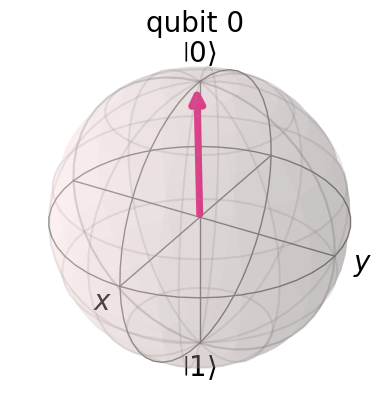

Reconstructing qubit state:  33%|███▎      | 1/3 [00:00<00:00,  2.54it/s]

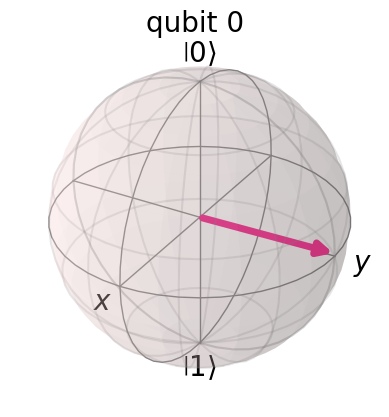

Reconstructing qubit state:  67%|██████▋   | 2/3 [00:00<00:00,  3.13it/s]

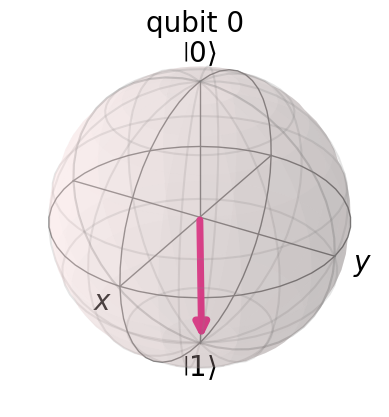

Reconstructing qubit state: 100%|██████████| 3/3 [00:00<00:00,  3.37it/s]


In [25]:
# progress bar
for j in tqdm(range(len(thetadef)), desc="Reconstructing qubit state"):
    compute_new_frame(j)